# Keyword Ontology

We have demonstrated similarity based on overlap of keywords, authors and organizations. Here we turn the similarity direction around and try to build an ontology of keywords based on their collocation across documents. In this setup, if K1 and K2 are collocated in 25 documents and K2 and K3 are collocated in 10, then we would consider K1 and K2 to be more strongly connected than K1 and K3.

In [1]:
import itertools
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import urllib

%matplotlib inline

## Extract document keyword pairs

We page through the latest index `nips2index` to extract all document to keyword mappings, and flatten them out into document keyword pairs.

In [2]:
SOLR_URL = "http://localhost:8983/solr/nips2index"

In [3]:
query_string = "*:*"
field_list = "id,keywords"
cursor_mark = "*"
num_docs, num_keywords = 0, 0
doc_keyword_pairs = []

while True:
    if num_docs % 1000 == 0:
        print("{:d} documents and {:d} keywords retrieved"
              .format(num_docs, num_keywords))
    payload = {
        "q": query_string,
        "fl": field_list,
        "sort": "id asc",
        "rows": 100,
        "cursorMark": cursor_mark
    }
    params = urllib.parse.urlencode(payload, quote_via=urllib.parse.quote_plus)
    search_url = SOLR_URL + "/select?" + params
    resp = requests.get(search_url)
    resp_json = json.loads(resp.text)
    docs = resp_json["response"]["docs"]
    
    docs_retrieved = 0
    for doc in docs:
        doc_id = int(doc["id"])
        try:
            keywords = doc["keywords"]
        except KeyError:
            keywords = []
        for keyword in keywords:
            doc_keyword_pairs.append((doc_id, keyword))
            num_keywords += 1
        num_docs += 1
        docs_retrieved += 1
    if docs_retrieved == 0:
        break

    # for next batch of ${rows} rows
    cursor_mark = resp_json["nextCursorMark"]

print("{:d} documents and {:d} keywords retrieved, COMPLETE"
      .format(num_docs, num_keywords))

0 documents and 0 keywords retrieved
1000 documents and 42509 keywords retrieved
2000 documents and 93621 keywords retrieved
3000 documents and 154889 keywords retrieved
4000 documents and 226967 keywords retrieved
5000 documents and 300000 keywords retrieved
6000 documents and 374288 keywords retrieved
7000 documents and 449760 keywords retrieved
7238 documents and 459061 keywords retrieved, COMPLETE


In [4]:
doc_keywords_df = pd.DataFrame(doc_keyword_pairs, columns=["doc_id", "keyword"])
doc_keywords_df.head()

,doc_id,keyword
0,0,learning representations
1,0,euclidean distance
2,0,neural network
3,0,computation time
4,0,time interval


## Join on doc_id, Group by keyword pair and Count

We join the dataframe with itself on `doc_id`, group by the pair (`keyword_l`, `keyword_r`) and then count each group size. The count is the strength of the relationship between pair of keywords given by how many times they appear together in the same document.

In [5]:
keyword_pairs_df = doc_keywords_df.join(doc_keywords_df, on="doc_id", how="inner",
                                       lsuffix="_l", rsuffix="_r")
keyword_pairs_df = keyword_pairs_df.drop(columns=["doc_id_l", "doc_id_r"])
keyword_pairs_df.head()

,doc_id,keyword_l,keyword_r
0,0,learning representations,learning representations
1,0,euclidean distance,learning representations
2,0,neural network,learning representations
3,0,computation time,learning representations
4,0,time interval,learning representations


In [6]:
keyword_pair_counts_df = (keyword_pairs_df.groupby(["keyword_l", "keyword_r"])
                          .size()
                          .reset_index(name="count")
                          .sort_values("count", ascending=False))
keyword_pair_counts_df.head(10)

,keyword_l,keyword_r,count
164128,machine learning,neural network,88
122684,information processing,neural network,85
231433,processing systems,neural network,82
190799,neural information,neural network,80
192245,neural network,neural network,69
125818,international conference,neural network,61
37526,computer science,neural network,60
177116,mit press,neural network,51
116795,ieee transactions,neural network,50
140604,learning algorithm,neural network,48


## Plot top 100 keywords

/Users/palsujit/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/palsujit/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/palsujit/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


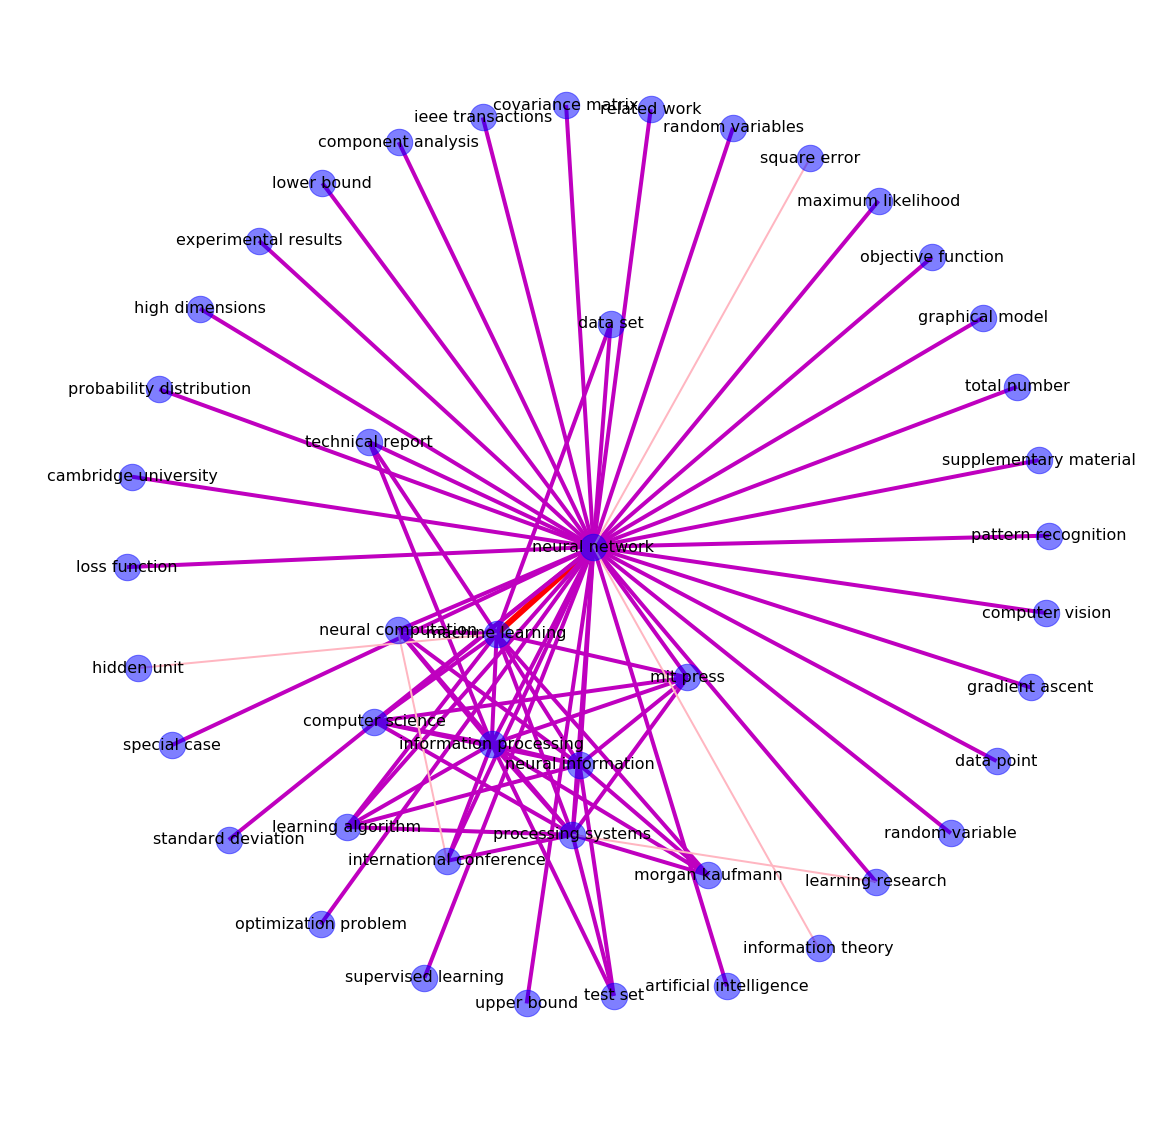

In [7]:
keyword_pair_counts = keyword_pair_counts_df.values[0:100, :]
max_count = np.max(keyword_pair_counts[:, 2])
keyword_pair_counts[:, 2] = keyword_pair_counts[:, 2] / max_count

G = nx.Graph()
for k1, k2, c in keyword_pair_counts:
    G.add_edge(k1, k2, weight=c)

edges_hi = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.7]
edges_md = [(u, v) for (u, v, d) in G.edges(data=True) 
            if d["weight"] > 0.3 and d["weight"] <= 0.7]
edges_lo = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.3]

plt.figure(figsize=(20, 20))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=700, node_color="b", alpha=0.5)

nx.draw_networkx_edges(G, pos, edgelist=edges_hi, width=6, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=edges_md, width=4, edge_color="m")
nx.draw_networkx_edges(G, pos, edgelist=edges_lo, width=2, edge_color="lightpink")
    
nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')


plt.axis('off')
plt.show()